In [2]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd
import pickle
import preprocess

Using TensorFlow backend.


In [3]:
# Creating dictionary of labels
class_labels = {str(x):x for x in range(10)}
class_labels.update({'+':10, 'times':11, '-':12 })
label_class = dict( zip(class_labels.values(), class_labels.keys() ))

# Loading data from .npy file and spliting into training and validation sets
path = '/Users/josejoy/Desktop/ECE 271B Stat Learning /project/Training Data/'
data, labels = preprocess.load_data(class_labels, path+'data_ver2.npy' , path+'labels_ver2.npy'
                                   , train = 0.85 , val = 0.15)


In [33]:
data = np.load(path+'labels_ver1.npy' )

In [34]:
data.shape

(21715, 1)

In [32]:
len(data[data[:,0]=='-'])

10001

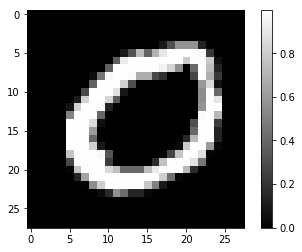

Label =  0


In [173]:
idx = np.random.randint(data['train'].shape[0])
plt.imshow(data['train'][idx,:].reshape(28,28),cmap = 'gray')
plt.colorbar()
plt.show()
print('Label = ',label_class[ np.argmax(labels['train'][idx,:])])



## Random Forest Model training

19.4043598403


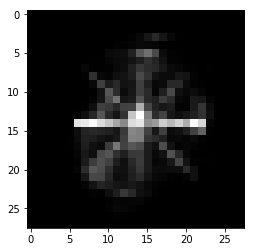

CPU times: user 50.3 s, sys: 425 ms, total: 50.7 s
Wall time: 51.2 s


In [163]:
%%time
train_label = np.argmax(labels['train'], axis = 1)
RFmodel = RandomForestClassifier(max_depth=4, n_estimators=2000, class_weight='balanced' )
RFmodel.fit(data['train'],train_label)
pred = RFmodel.predict(data['val'])
test_label = np.argmax(labels['val'], axis = 1)
error1 = np.sum([pred!=test_label])*100/test_label.shape[0]
print( error1 )
plt.imshow( RFmodel.feature_importances_.reshape([28,28]) ,cmap = 'gray' )
plt.show()

## Saving trained model
# filename = './trained models/RFmodel_ver1.1.sav'
# pickle.dump(RFmodel, open(filename, 'wb'))

## AdaBoost Stage 1 ( BInary classifer for Digits - Character classification)

Stage1 error =  0.0


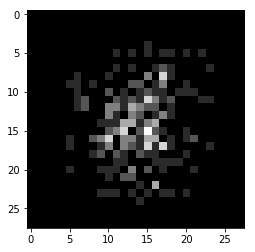

In [165]:
%%time

# converting traing labels to binary, for  digits / characters
bin_label = np.argmax(labels['train'], axis = 1)
bin_label[bin_label<10] = 1 # digits have label 1
bin_label[bin_label>=10] = -1 # symbols have label -1

stage1 = AdaBoostClassifier( n_estimators=250)
stage1.fit(data['train'],bin_label )
pred1 = stage1.predict(data['val'])

# converting testing labels to binary, for  digits / characters
test = np.argmax(labels['val'], axis = 1)
test[test<10] = 1
test[test>=10] = -1

print( 'Stage1 error = ',sum( pred1!=test )*100/ test.shape[0])
plt.imshow( stage1.feature_importances_.reshape([28,28]) ,cmap = 'gray' )
plt.show()

## Saving trained model
# filename = './trained models/Adaboost_stage1_ver1.1.sav'
# pickle.dump(stage1, open(filename, 'wb'))

## AdaBoost Stage 2 (Digits classifier and symbol classifier)

In [167]:
# Creating labels for digits classifier, -1 is the class for any non digit symbol 
label1 = np.argmax(labels['train'],axis=1)
label1[label1>=10] = -1

# Creating labels for symbol classifier, -1 is the class for any non symbol digit
label2 = np.argmax(labels['train'],axis=1)
label2[label2<10] = -1


# contains binary classifiers (one vs all) for each digit
digits = AdaBoostClassifier( n_estimators=500, learning_rate=0.1) 
digits.fit(data['train'][label1!=-1],label1[label1!=-1])

# contains binary classifiers (one vs all) for each digit
chars =  AdaBoostClassifier( n_estimators=500, learning_rate=0.1) 
chars.fit(data['train'][label2!=-1],label2[label2!=-1])

pred1 = stage1.predict(data['val'])
pred_d = digits.predict(data['val'])
pred_c = chars.predict(data['val'])
test_full = np.argmax(labels['val'],axis=1)
pred_d[pred1==-1] = -1
pred_c[pred1==1] = -1
pred = np.column_stack((pred_d,pred_c))
predx = np.max(pred,axis= 1)
print( 'Stage2 error = ',sum( predx!=test_full )*100/ test_full.shape[0])

## Saving data
# filename = './trained models/Adaboost_digits_ver1.1.sav'
# pickle.dump(digits, open(filename, 'wb'))
# filename = './trained models/Adaboost_chars_ver1.1.sav'
# pickle.dump(chars, open(filename, 'wb'))


Stage2 error =  18.4218606079


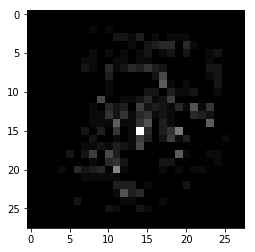

In [169]:
plt.imshow( digits.feature_importances_.reshape([28,28]) ,cmap = 'gray' )
plt.show()